In [1]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

# I have saved my API token with "wandb_api" as Label. 
# If you use some other Label make sure to change the same below. 
wandb_api = user_secrets.get_secret("wandb_api") 

In [2]:
from tqdm.auto import tqdm
import os

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split , StratifiedKFold


import tensorflow as tf 
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input,Dense, LSTM, RNN, Bidirectional, GlobalAveragePooling2D , Dropout, Conv1D, Flatten

from transformers import TFAutoModel , AutoTokenizer
# import ray
# from ray import tune

!pip install wandb --upgrade
import wandb
from wandb.keras import WandbCallback

wandb.login(key=wandb_api)

2022-04-04 22:03:17.540272: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-04 22:03:17.540377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


     |████████████████████████████████| 1.7 MB 2.3 MB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.2
    Uninstalling wandb-0.12.2:
      Successfully uninstalled wandb-0.12.2


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
class config:
    train_path = "../input/combined-augmented-fasttext-datasets-acl/combined_augmented_fasttext_training_dataset.csv"
    val_path = "../input/dravidianlangtech2022-personal/Validation_Data_Combined.csv"
    save_dir = "./result"
    seed = 55
    try:
        AUTOTUNE = tf.data.AUTOTUNE   
    except:
        AUTOTUNE = tf.data.experimental.AUTOTUNE 
    epochs = 50
    max_len = 64
    batch_size = 32
    hf_path = "google/muril-base-cased"
def seed_everything(seed = config.seed):
    print(f"seeded everything to seed {seed}")
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
if not os.path.exists(config.save_dir):
    os.makedirs(config.save_dir)
seed_everything()
wandb.init(project="With N_Augmented Abusive Comment Detction at DravidianLangTech", entity="bp-high",config={"learning_rate": 0.1,
  "epochs": 50,
  "batch_size": 32})  
    

wandb: Currently logged in as: bp-high (use `wandb login --relogin` to force relogin)


seeded everything to seed 55


2022-04-04 22:03:39.180211: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-04 22:03:39.180480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
df_train = pd.read_csv(config.train_path)
df_val = pd.read_csv(config.val_path)
# df_train = df_train[df_train.label != 'None-of-the-above']
# df_val = df_val[df_val.label != 'None-of-the-above']

In [5]:
df_train

,Unnamed: 0,index,label,text
0,2904,2284,Transphobic,io samy 9kitta maatuna summa vituvangala
1,4420,4423,Counter-speech,subash 24jc statics pesite irunga....ungalala...
2,7896,1953,Hope-Speech,H ராஜா பேச்சில் உண்மை உள்ளது...
3,1297,1366,Hope-Speech,கணவன் மனைவி உறவு நன்றாக இருக்கணும்னா என்றால்; ...
4,4642,4171,Counter-speech,stop role makes romantic Samuthirakani station...
...,...,...,...,...
41024,2503,1039,Xenophobia,BRAHMIN MEDIA JAIN சன்ஸ்தா SELLING INDIA TO IS...
41025,1926,5683,Misandry,"Movie, traditional yeppavume innoru hinduva ke..."
41026,1940,5367,Counter-speech,Idhil sadhiyum illai madamum illai sariyana pa...
41027,418,2223,Transphobic,Naama asingaththukku payandhu odhungi poradha ...


In [6]:
df_val

,Unnamed: 0,label,text
0,0,None-of-the-above,Black saree u r so hot
1,1,Counter-speech,Halo first ayunga kai thatti amount keatkyrang...
2,2,None-of-the-above,Hello...... manithana sollunga.......... prama...
3,3,Xenophobia,China kaaranai nalla kalaipan daily I am enjoy...
4,4,None-of-the-above,Onnota ponnu ipdi Panna vituviya
...,...,...,...
2041,555,None-of-the-above,Badri Narayanan இந்து தர்மம் என்பது என்ன
2042,556,None-of-the-above,நீங்க எழுதுங்க...நாங்க படிக்கின்றோம்
2043,557,Misandry,சீமானுக்கு அவன் பொண்டாட்டியே அம்மாவ விபச்சாரி ...
2044,558,None-of-the-above,புரட்சி தமிழன் சீமான் அண்ணணுக்கு சார்பா ஒரு பத...


In [7]:
df_train.label.value_counts()

Counter-speech       5467
Homophobia           5175
Misandry             5104
Xenophobia           5096
Hope-Speech          5083
Transphobic          5053
Misogyny             5040
None-of-the-above    5011
Name: label, dtype: int64

In [8]:
df_train = df_train.replace({'Counter-speech':0,
                             'Homophobia':1, 
                             'Hope-Speech':2, 
                             'Misandry':3, 
                             'Misogyny':4,
                             'None-of-the-above':5,
                             'Transphobic':6,
                             'Xenophobia':7})
df_val = df_val.replace({'Counter-speech':0,
                             'Homophobia':1, 
                             'Hope-Speech':2, 
                             'Misandry':3, 
                             'Misogyny':4,
                             'None-of-the-above':5,
                             'Transphobic':6,
                             'Xenophobia':7})


In [9]:
df_train = df_train.sample(frac=1)
df_val = df_val.sample(frac=1)

In [10]:
def count(dataframe):
    lengths = []
    for i in tqdm(dataframe['text']):
        length = len(i.split(' '))
        lengths.append(length)
    lengths = np.array(lengths)
    print(f"the average length of the excerpts is {np.mean(lengths)}, the median length is {np.median(lengths)} ,  the maximum length is {np.max(lengths)},the minimum length is {np.min(lengths)}")
    return lengths

In [11]:
lengths = count(df_train)

  0%|          | 0/41029 [00:00<?, ?it/s]

the average length of the excerpts is 17.706963367374296, the median length is 12.0 ,  the maximum length is 185,the minimum length is 1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

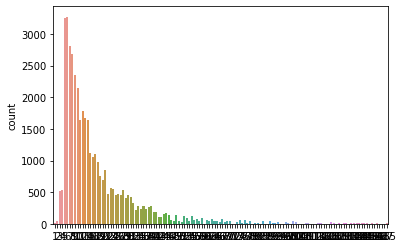

In [12]:
sns.countplot(lengths)

In [13]:
#Tokenization Process
tokenizer = AutoTokenizer.from_pretrained(config.hf_path)
tokenizer.save_pretrained(os.path.join(config.save_dir , "muril_tokenizer"))

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

('./result/muril_tokenizer/tokenizer_config.json',
 './result/muril_tokenizer/special_tokens_map.json',
 './result/muril_tokenizer/vocab.txt',
 './result/muril_tokenizer/added_tokens.json')

In [14]:
def fast_encode(texts, tokenizer, chunk_size=512, maxlen=config.max_len):
    
    input_ids = []
    tt_ids = []
    at_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size]
        encs = tokenizer(
                    text_chunk,
                    max_length = config.max_len,
                    padding='max_length',
                    truncation=True
                    )
        
        input_ids.extend(encs['input_ids'])
        tt_ids.extend(encs['token_type_ids'])
        at_ids.extend(encs['attention_mask'])
    
    return {'input_ids': input_ids, 'token_type_ids': tt_ids, 'attention_mask':at_ids}

In [15]:
train_token_data = fast_encode(list(df_train['text'].values), tokenizer)
train_token_data['label'] = list(df_train['label'].values)
val_token_data = fast_encode(list(df_val['text'].values), tokenizer)
val_token_data['label'] = list(df_val['label'].values)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
df_tokenized_train = pd.DataFrame(train_token_data)
len(df_tokenized_train['input_ids'][0])

64

In [17]:
df_tokenized_val = pd.DataFrame(val_token_data)
len(df_tokenized_val['input_ids'][0])

64

In [18]:
del train_token_data 
del val_token_data 

In [19]:
#preparing dataset
def train_prep_function(embeddings , target):
  input_ids = embeddings['input_ids']
  attention_mask = embeddings['attention_mask']
  token_type_ids = embeddings['token_type_ids']

  target = tf.cast(target, tf.int32)
  
  return {'input_ids': input_ids ,'token_type_ids':token_type_ids,'attention_mask': attention_mask}, target

In [20]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-04-04 22:03:55.836012: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-04 22:03:55.838802: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-04 22:03:55.838853: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-04 22:03:55.838884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dd9fa9fb1494): /proc/driver/nvidia/version does not exist
2022-04-04 22:03:55.841726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


In [21]:
#taken from old keras source code

# def f1_score(y_true, y_pred): 
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [22]:
def create_model(transformer_model):
  input_id_layer = Input(shape=(config.max_len,) ,dtype = tf.int32 , name = 'input_ids')
  attention_mask_layer = Input(shape=(config.max_len,) , dtype = tf.int32 , name = 'attention_mask')
  token_type_layer = Input(shape=(config.max_len,) , dtype = tf.int32 , name = 'token_type_ids')
  transformer = transformer_model(input_ids = input_id_layer ,token_type_ids=token_type_layer,attention_mask = attention_mask_layer)[0]
  

  x = Dropout(0.5)(transformer)
  x = Conv1D(1,1)(x)
  x = Flatten()(x) 
  predictions = Dense(8, activation = "softmax")(x)

  model = Model(inputs=[input_id_layer ,token_type_layer, attention_mask_layer], outputs = predictions)
  model.compile(
      optimizer = Adam(learning_rate= 0.01),
      metrics = ['accuracy'],
      loss = 'sparse_categorical_crossentropy'
  )

  return model

Downloading:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Some layers from the model checkpoint at google/muril-base-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 237556224   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

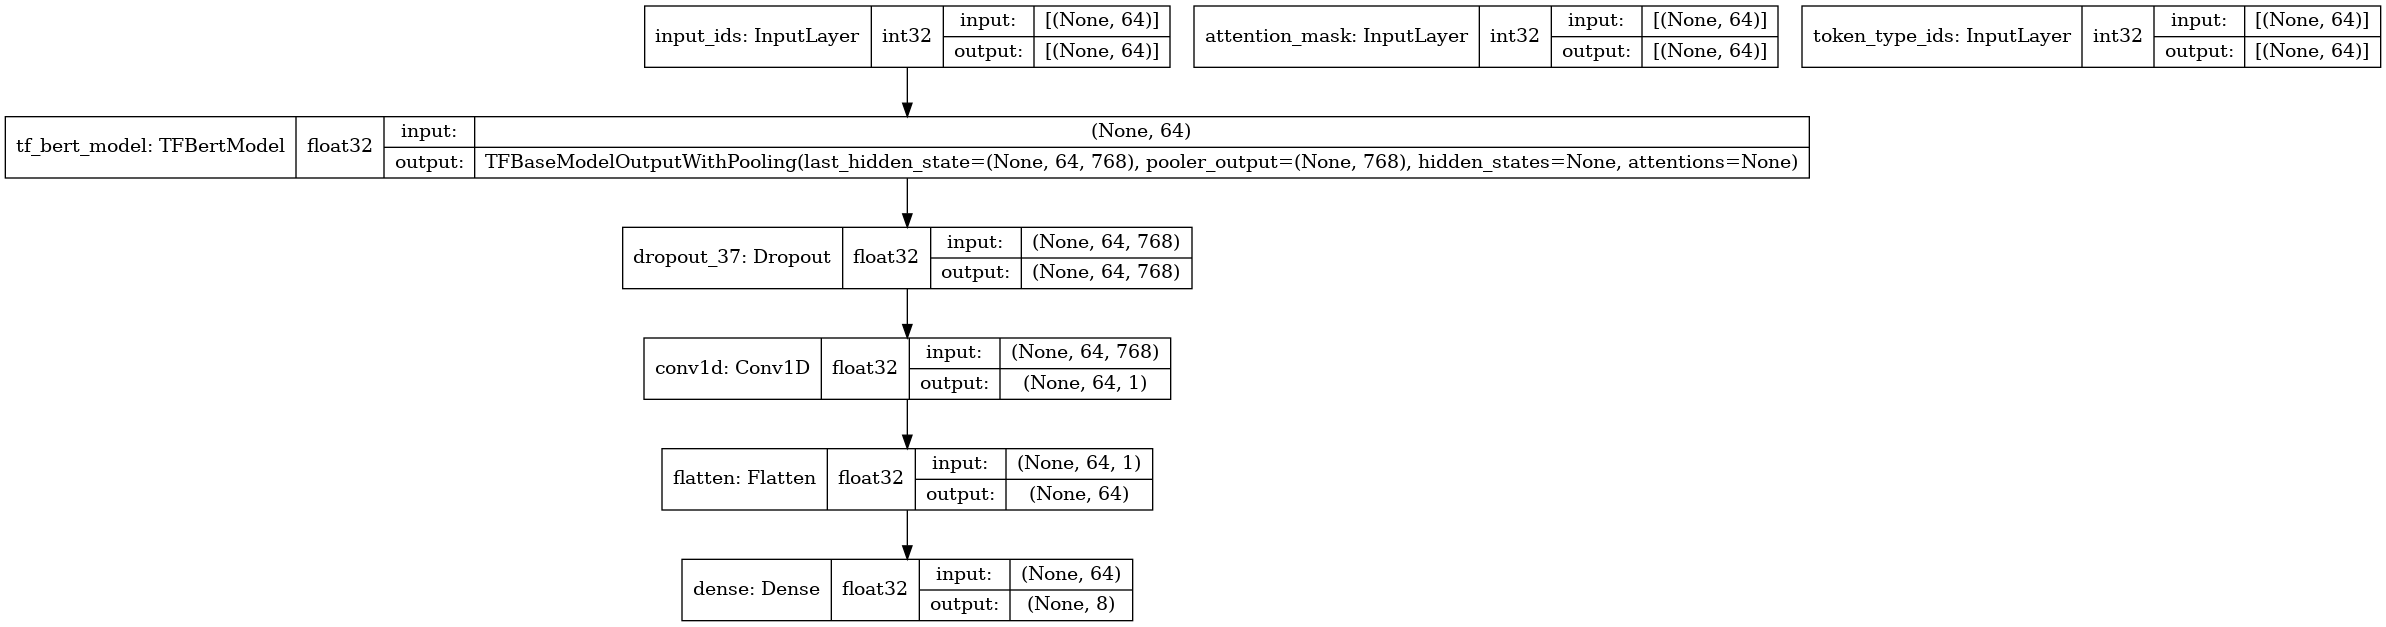

In [23]:
with strategy.scope():
  transformer_model = TFAutoModel.from_pretrained(config.hf_path)
  transformer_model.bert.trainable = False 
  model = create_model(transformer_model)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,show_dtype=True)

In [24]:
from sklearn.metrics import accuracy_score
train_embeddings = {'input_ids': df_tokenized_train['input_ids'].tolist() ,'token_type_ids': df_tokenized_train['token_type_ids'].tolist(),"attention_mask":df_tokenized_train['attention_mask'].tolist()}
test_embeddings = {'input_ids': df_tokenized_val['input_ids'].tolist() ,'token_type_ids': df_tokenized_val['token_type_ids'].tolist(),"attention_mask":df_tokenized_val['attention_mask'].tolist()}
y_train = df_tokenized_train['label']
y_test = df_tokenized_val['label']
train_dataset = tf.data.Dataset.from_tensor_slices((train_embeddings , y_train))
train_dataset = (
      train_dataset
      .shuffle(1024*2)
      .map(train_prep_function , num_parallel_calls = config.AUTOTUNE)
      .repeat()
      .batch(config.batch_size)
      .prefetch(config.AUTOTUNE)
  )
test_dataset = tf.data.Dataset.from_tensor_slices((test_embeddings , y_test ))
test_dataset = (
      test_dataset
      .map(train_prep_function , num_parallel_calls = config.AUTOTUNE)
      .batch(config.batch_size)
      .prefetch(config.AUTOTUNE)
  )
train_steps = len(train_embeddings['input_ids'])//config.batch_size//4
validation_steps = len(test_embeddings['input_ids'])//config.batch_size
model_checkpoint = ModelCheckpoint(f'{config.save_dir}/muril_fold_trained.h5',monitor = 'val_accuracy', verbose = 1, save_best_only = True , save_weights_only = True, mode = 'max')
model.fit(train_dataset, steps_per_epoch= train_steps, validation_data= test_dataset, validation_steps= validation_steps,epochs = config.epochs, callbacks = [model_checkpoint,WandbCallback()])


Epoch 1/50
320/320 [==============================] - 37s 48ms/step - loss: 2.0130 - accuracy: 0.2004 - val_loss: 1.8127 - val_accuracy: 0.4077

Epoch 00001: val_accuracy improved from -inf to 0.40774, saving model to ./result/muril_fold_trained.h5


wandb: ERROR Can't save model, h5py returned error: 


Epoch 2/50
320/320 [==============================] - 7s 22ms/step - loss: 1.9103 - accuracy: 0.2487 - val_loss: 1.6741 - val_accuracy: 0.4211

Epoch 00002: val_accuracy improved from 0.40774 to 0.42113, saving model to ./result/muril_fold_trained.h5
Epoch 3/50
320/320 [==============================] - 7s 23ms/step - loss: 1.8659 - accuracy: 0.2733 - val_loss: 1.7085 - val_accuracy: 0.3576

Epoch 00003: val_accuracy did not improve from 0.42113
Epoch 4/50
320/320 [==============================] - 7s 23ms/step - loss: 1.8349 - accuracy: 0.2839 - val_loss: 1.5408 - val_accuracy: 0.4325

Epoch 00004: val_accuracy improved from 0.42113 to 0.43254, saving model to ./result/muril_fold_trained.h5
Epoch 5/50
320/320 [==============================] - 7s 23ms/step - loss: 1.8399 - accuracy: 0.2815 - val_loss: 1.5454 - val_accuracy: 0.4821

Epoch 00005: val_accuracy improved from 0.43254 to 0.48214, saving model to ./result/muril_fold_trained.h5
Epoch 6/50
320/320 [============================

In [25]:
df_val.label.value_counts()

5    1263
3     322
0     131
7      99
4      74
2      64
1      51
6      42
Name: label, dtype: int64

In [26]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 827 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2046 non-null   int64 
 1   label       2046 non-null   int64 
 2   text        2046 non-null   object
dtypes: int64(2), object(1)
memory usage: 63.9+ KB
